# AI Predictions (PD Features Only)

The dataset used within this notebook utilises features that where used for Poisson distribution predictions only. This means that any other in-game football statistics were not included. Note that this script utilises the best performing set of model parameters that were obtained through the GridSearchCV from the other Jupyter Notebook.

## Prerequisites

This section consists of necessary imports and seed setting. Seeds are set to ensure having the same dataset splits whenever the script is executed.

In [1]:
# Pandas and NumPy
import pandas as pd
import numpy as np

# Other
from matplotlib import pyplot

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# scikit-learn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# TensorFlow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Setting a random seed to both TensorFlow (Keras) and NumPy
# This will ensure the same predictions are conducted over the same set (only changes if model paramaters change)

# https://stackoverflow.com/a/46119607/6361493
np.random.seed(42)
tf.random.set_seed(42)

## Retrieving & Cleaning The Data

This section retrieves the developed dataset (can be either queried directly from the database or by using the provided CSV).

In the `full_time_result` field:
<ul>
    <li>1 = Home Win</li>
    <li>0 = Draw</li>
    <li>2 = Away Win</li>
</ul>

In [3]:
betstats_data = pd.read_csv('football_dataset_pd_features_only.csv')

display(betstats_data)

fixture_id  league_season  league_id max_lr_fixture_date  \
0             115           2018         39    17/09/2018 19:00   
1             116           2018         39    17/09/2018 19:00   
2             117           2018         39    17/09/2018 19:00   
3             118           2018         39    17/09/2018 19:00   
4             119           2018         39    17/09/2018 19:00   
...           ...            ...        ...                 ...   
24060      710808           2021         39    19/02/2022 15:00   
24061      710812           2021         39    19/02/2022 15:00   
24062      717741           2021         42    19/02/2022 15:00   
24063      717742           2021         42    19/02/2022 15:00   
24064      717743           2021         42    19/02/2022 15:00   

       teams_home_id  league_avg_join  fp_home  teams_away_id  fp_away  \
0                 36                5        5             38        5   
1                 44                5        5             35        5   
2                 43                5        5             50        5   
3                 52                5        5             34        5   
4                 46                5        5             37        5   
...              ...              ...      ...            ...      ...   
24060             51               24       24             44       22   
24061             50               25       25             47       23   
24062           1340               31       31           1339       29   
24063           1368               32       32           1334       30   
24064           1381               32       32           1351       29   

       home_attack_ft  ...  home_defence_1h  avg_goals_for_average_home_1h  \
0               1.300  ...            2.370                          0.787   
1               0.325  ...            2.370                          0.787   
2               0.650  ...            0.790                          0.787   
3               1.000  ...            0.790                          0.787   
4               0.975  ...            1.580                          0.787   
...               ...  ...              ...                            ...   
24060           0.570  ...            0.960                          0.733   
24061           1.708  ...            0.171                          0.726   
24062           0.568  ...            0.695                          0.528   
24063           0.938  ...            1.076                          0.663   
24064           1.027  ...            0.462                          0.663   

       avg_goals_for_average_away_1h  home_attack_2h  away_defence_2h  \
0                              0.608           0.667            1.000   
1                              0.608           1.000            1.319   
2                              0.608           0.667            0.660   
3                              0.608           1.000            0.660   
4                              0.608           0.667            1.979   
...                              ...             ...              ...   
24060                          0.566           0.423            0.883   
24061                          0.627           1.608            0.982   
24062                          0.484           0.524            1.117   
24063                          0.386           0.763            0.687   
24064                          0.386           1.271            1.004   

       away_attack_2h  home_defence_2h  avg_goals_for_average_home_2h  \
0               2.401            0.619                          0.750   
1               1.200            1.238                          0.750   
2               1.200            1.238                          0.750   
3               1.000            1.856                          0.750   
4               1.000            1.000                          0.750   
...               ...              ...                       

In [4]:
# Dropping malformed records
# NULL values skew ML training

betstats_data = betstats_data.dropna()

display(betstats_data)

fixture_id  league_season  league_id max_lr_fixture_date  \
0             115           2018         39    17/09/2018 19:00   
1             116           2018         39    17/09/2018 19:00   
2             117           2018         39    17/09/2018 19:00   
3             118           2018         39    17/09/2018 19:00   
4             119           2018         39    17/09/2018 19:00   
...           ...            ...        ...                 ...   
24060      710808           2021         39    19/02/2022 15:00   
24061      710812           2021         39    19/02/2022 15:00   
24062      717741           2021         42    19/02/2022 15:00   
24063      717742           2021         42    19/02/2022 15:00   
24064      717743           2021         42    19/02/2022 15:00   

       teams_home_id  league_avg_join  fp_home  teams_away_id  fp_away  \
0                 36                5        5             38        5   
1                 44                5        5             35        5   
2                 43                5        5             50        5   
3                 52                5        5             34        5   
4                 46                5        5             37        5   
...              ...              ...      ...            ...      ...   
24060             51               24       24             44       22   
24061             50               25       25             47       23   
24062           1340               31       31           1339       29   
24063           1368               32       32           1334       30   
24064           1381               32       32           1351       29   

       home_attack_ft  ...  home_defence_1h  avg_goals_for_average_home_1h  \
0               1.300  ...            2.370                          0.787   
1               0.325  ...            2.370                          0.787   
2               0.650  ...            0.790                          0.787   
3               1.000  ...            0.790                          0.787   
4               0.975  ...            1.580                          0.787   
...               ...  ...              ...                            ...   
24060           0.570  ...            0.960                          0.733   
24061           1.708  ...            0.171                          0.726   
24062           0.568  ...            0.695                          0.528   
24063           0.938  ...            1.076                          0.663   
24064           1.027  ...            0.462                          0.663   

       avg_goals_for_average_away_1h  home_attack_2h  away_defence_2h  \
0                              0.608           0.667            1.000   
1                              0.608           1.000            1.319   
2                              0.608           0.667            0.660   
3                              0.608           1.000            0.660   
4                              0.608           0.667            1.979   
...                              ...             ...              ...   
24060                          0.566           0.423            0.883   
24061                          0.627           1.608            0.982   
24062                          0.484           0.524            1.117   
24063                          0.386           0.763            0.687   
24064                          0.386           1.271            1.004   

       away_attack_2h  home_defence_2h  avg_goals_for_average_home_2h  \
0               2.401            0.619                          0.750   
1               1.200            1.238                          0.750   
2               1.200            1.238                          0.750   
3               1.000            1.856                          0.750   
4               1.000            1.000                          0.750   
...               ...              ...                       

In [5]:
# Getting column information
col_list = []

for col in betstats_data.columns:
    col_list.append(col)

col_list.remove('max_lr_fixture_date')
    
col_len = len(col_list)
col_adj = col_len - 1
    
# print(col_len)
# print(col_list)


# Allocating X and Y
x = betstats_data[[col for col in col_list[0:col_adj]]].astype(float)
y = betstats_data[[col for col in col_list[col_adj:]]]

# Categorising labels (0/1/2)
y = np_utils.to_categorical(y)

# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19252, 26)
(19252, 3)
(4813, 26)
(4813, 3)


## Feature Correlation

Conducting some analysis on the list of features within the dataset.

<AxesSubplot:>

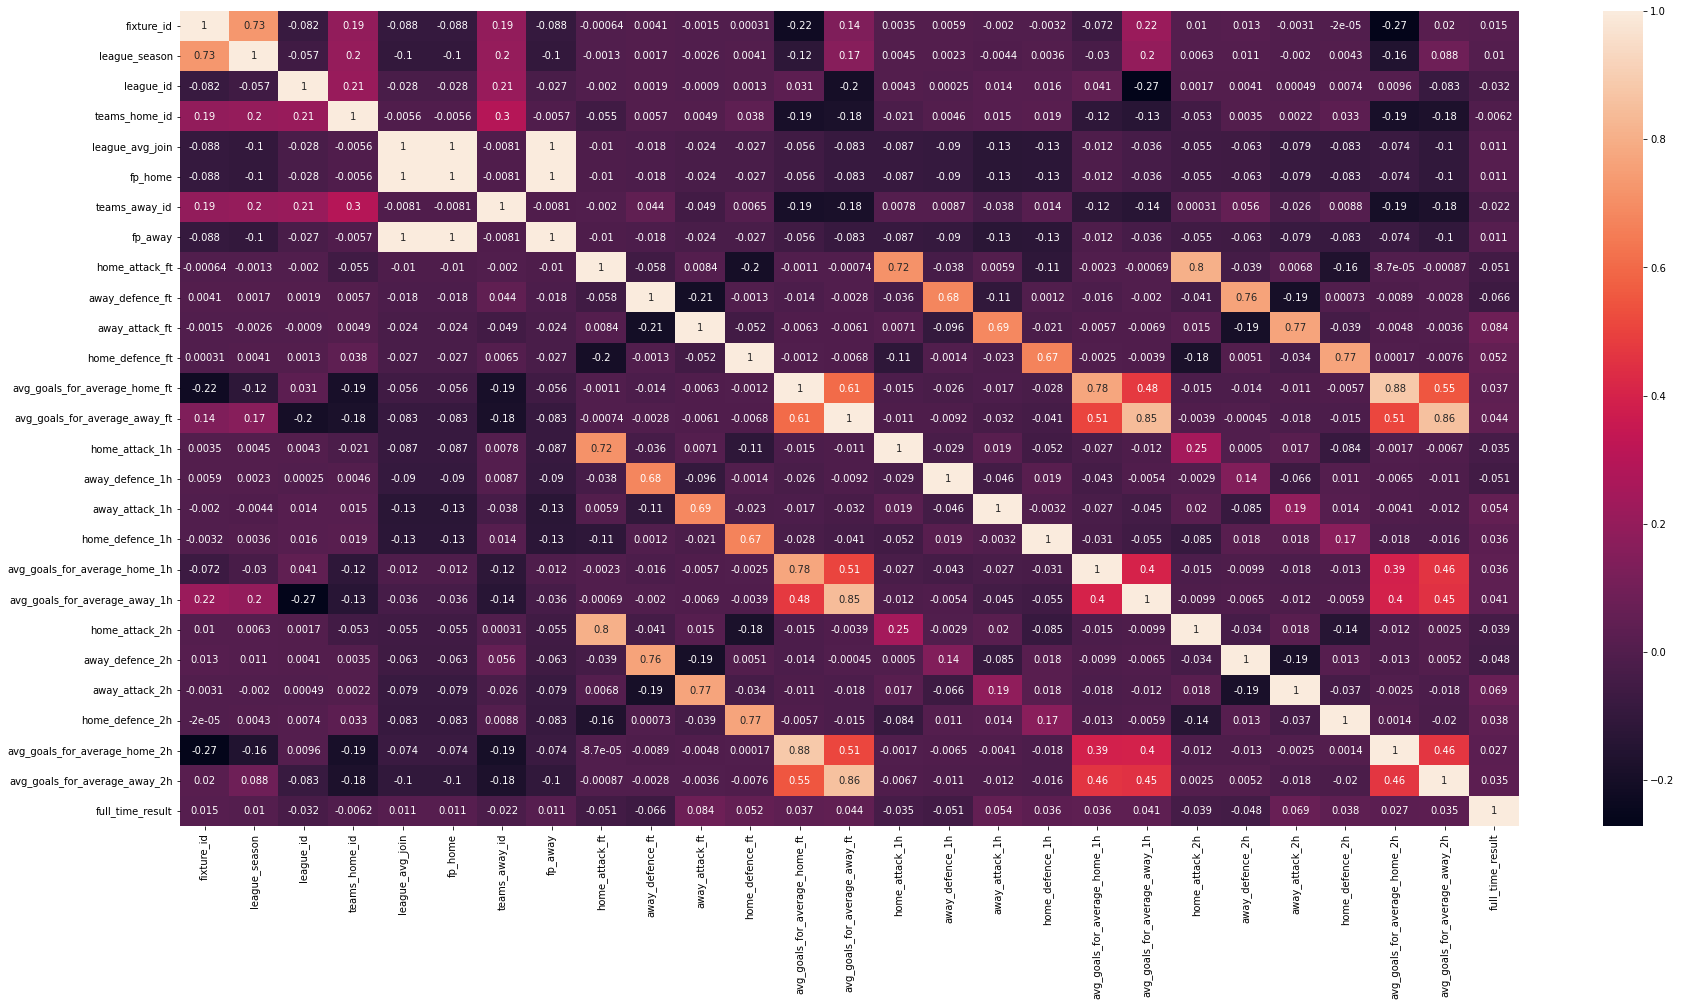

In [6]:
cor = betstats_data.corr()

plt.figure(figsize=(30, 15))
sns.heatmap(cor, annot=True)

## Normal Sequential Model

In [7]:
# I know that the intro says that we are using the same exact parameters here
# However note that the first node cannot have 75 due to the different number of fields
# That value was altered to 25

model = Sequential()
model.add(Dense(25, input_dim=col_adj, activation='relu'))
model.add(Dropout(0.0001))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, batch_size=32, validation_split=0.1, verbose=2, epochs=125, shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                675       
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 78        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/125
542/542 - 1s - loss: 3059.4141 - accuracy: 0.3329 - val_loss: 144.4630 - val_accuracy: 0.3811
Epoch 2/125
542/542 - 0s - loss: 202.7549 - accuracy: 0.3488 - val_loss: 318.6818 - val_accuracy: 0.2949
Epoch 3/125
542/542 - 0s - loss: 204.3457 - accuracy: 0.3471 - val_loss: 127.7019 - val_accuracy: 0.3037
Epoch 4/125
542/542 - 0s - loss: 190.2464 - accuracy: 0.3570 - val_loss:

Epoch 72/125
542/542 - 0s - loss: 114.7690 - accuracy: 0.3633 - val_loss: 81.7208 - val_accuracy: 0.4372
Epoch 73/125
542/542 - 0s - loss: 116.6678 - accuracy: 0.3610 - val_loss: 116.1981 - val_accuracy: 0.3058
Epoch 74/125
542/542 - 0s - loss: 123.8036 - accuracy: 0.3609 - val_loss: 66.7716 - val_accuracy: 0.3032
Epoch 75/125
542/542 - 0s - loss: 144.5010 - accuracy: 0.3655 - val_loss: 137.0653 - val_accuracy: 0.4496
Epoch 76/125
542/542 - 0s - loss: 137.2379 - accuracy: 0.3590 - val_loss: 101.1031 - val_accuracy: 0.4361
Epoch 77/125
542/542 - 0s - loss: 125.3143 - accuracy: 0.3663 - val_loss: 46.6249 - val_accuracy: 0.3022
Epoch 78/125
542/542 - 0s - loss: 127.6692 - accuracy: 0.3682 - val_loss: 179.8625 - val_accuracy: 0.4735
Epoch 79/125
542/542 - 0s - loss: 138.6987 - accuracy: 0.3617 - val_loss: 112.3206 - val_accuracy: 0.2980
Epoch 80/125
542/542 - 0s - loss: 129.2862 - accuracy: 0.3627 - val_loss: 127.1666 - val_accuracy: 0.2928
Epoch 81/125
542/542 - 0s - loss: 118.4542 - accu

In [8]:
# Predicting Using Sequential Model
pred_test = model.predict(x_test)
print(pred_test)

y_pred_classes = np.argmax(pred_test, axis=1)
print(y_pred_classes)

score = model.evaluate(x_test, y_test)
print('Accuracy Score:', score)

[[0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.3577071e-09 9.8783374e-01 1.2166227e-02]
 [5.2212637e-02 9.4745654e-01 3.3086073e-04]
 ...
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [6.2451149e-06 1.1824926e-02 9.8816890e-01]
 [0.0000000e+00 1.0000000e+00 2.1737183e-31]]
[1 1 1 ... 1 2 1]
151/151 [==============================] - 0s 320us/step - loss: 87.5248 - accuracy: 0.4453
Accuracy Score: [87.52478790283203, 0.4452524483203888]


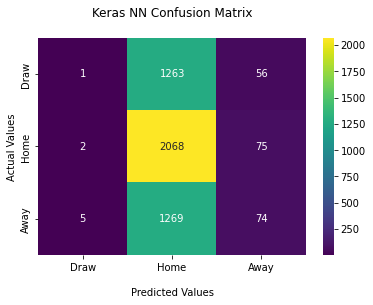

In [9]:
#Generate the confusion matrix
y_test_arg = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(y_test_arg, y_pred_classes)

ax = sns.heatmap(cf_matrix, annot=True, cmap='viridis', fmt='d')

ax.set_title('Keras NN Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Draw', 'Home', 'Away'])
ax.yaxis.set_ticklabels(['Draw', 'Home', 'Away'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [10]:
print(classification_report(y_test_arg, y_pred_classes))

              precision    recall  f1-score   support

           0       0.12      0.00      0.00      1320
           1       0.45      0.96      0.61      2145
           2       0.36      0.05      0.10      1348

    accuracy                           0.45      4813
   macro avg       0.31      0.34      0.24      4813
weighted avg       0.34      0.45      0.30      4813



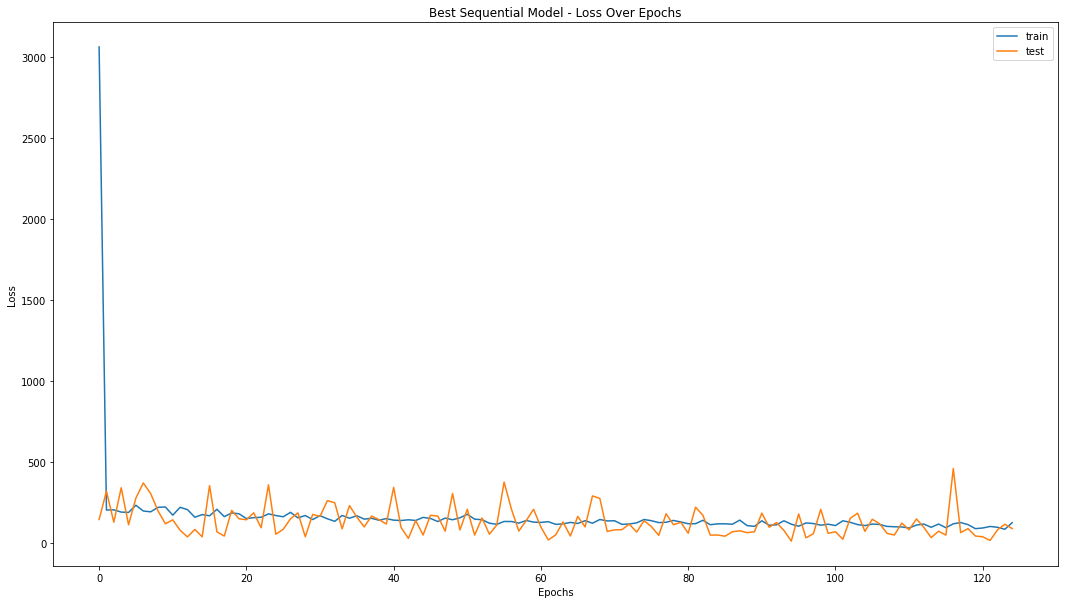

In [11]:
pyplot.figure(figsize=(18,10), dpi=72)
pyplot.title('Best Sequential Model - Loss Over Epochs')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()

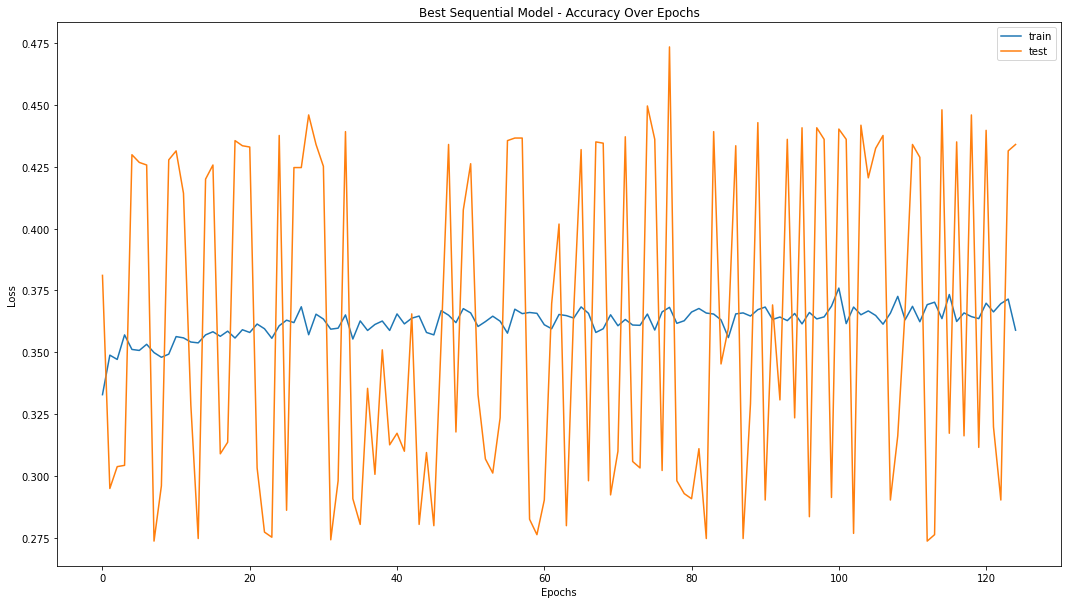

In [12]:
pyplot.figure(figsize=(18,10), dpi=72)
pyplot.title('Best Sequential Model - Accuracy Over Epochs')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()

## Normal RandomForest Model

In [13]:
# I know that the intro says that we are using the same exact parameters here
# However note that the 'max_features' cannot have 50 due to the different number of fields
# That value was altered to 25

model = RandomForestClassifier(bootstrap = True,
                               max_depth = 80,
                               max_features = 25,
                               min_samples_leaf = 3,
                               min_samples_split = 8,
                               n_estimators = 100,
                               random_state = 42)

model.fit(x_train, y_train)

RandomForestClassifier(max_depth=80, max_features=25, min_samples_leaf=3,
                       min_samples_split=8, random_state=42)

In [14]:
pred_test = model.predict(x_test)
y_pred_classes = np.argmax(pred_test, axis=1)

# Will always be close to 1 (since it knows the label)
score = model.score(x_train, y_train)
print(score)

# Actual prediction accuracy
score = model.score(x_test, y_test)
print('Accuracy Score:', score)

0.9303448992312487
Accuracy Score: 0.18657801786827344


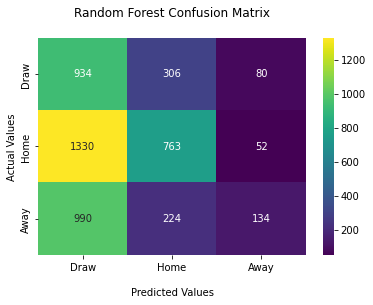

In [15]:
# Generate the confusion matrix
y_test_arg = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(y_test_arg, y_pred_classes)

ax = sns.heatmap(cf_matrix, annot=True, cmap='viridis', fmt='d')

ax.set_title('Random Forest Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Draw', 'Home', 'Away'])
ax.yaxis.set_ticklabels(['Draw', 'Home', 'Away'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
print(classification_report(y_test_arg, y_pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.71      0.41      1320
           1       0.59      0.36      0.44      2145
           2       0.50      0.10      0.17      1348

    accuracy                           0.38      4813
   macro avg       0.46      0.39      0.34      4813
weighted avg       0.48      0.38      0.36      4813



## Notes

For further visualisations, kindly refer to the entire write-up or by clicking on this [link](https://docs.google.com/spreadsheets/d/1i-WSEkhrl4q6TLL68K2F5h8F2f2bGpYCKbM4Kk3aXQY/edit).